## Predicción de precios de la gasolina

### Librerías comunes

In [546]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Importación Dataset

In [547]:
df_oil = pd.read_csv('Diary_Europe_Brent_Spot_Price_FOB.csv')

EDA

In [548]:
df_oil.head(7)

,Day,Europe Brent Spot Price FOB Dollars per Barrel
0,09/11/2023,91.97
1,09/8/2023,91.85
2,09/7/2023,91.16
3,09/6/2023,91.79
4,09/5/2023,91.25
5,09/4/2023,90.42
6,09/1/2023,89.98


In [549]:
df_oil.columns

Index(['Day', 'Europe Brent Spot Price FOB  Dollars per Barrel'], dtype='object')

In [550]:
df_oil.rename(columns={'Europe Brent Spot Price FOB  Dollars per Barrel': 'Price'}, inplace=True)

In [551]:
df_oil.head(7)

,Day,Price
0,09/11/2023,91.97
1,09/8/2023,91.85
2,09/7/2023,91.16
3,09/6/2023,91.79
4,09/5/2023,91.25
5,09/4/2023,90.42
6,09/1/2023,89.98


In [552]:
df_oil['Day'].max()

'12/9/2022'

In [553]:
df_oil.tail(7)

,Day,Price
9208,05/28/1987,18.60
9209,05/27/1987,18.60
9210,05/26/1987,18.63
9211,05/25/1987,18.60
9212,05/22/1987,18.55
9213,05/21/1987,18.45
9214,05/20/1987,18.63


In [554]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9215 entries, 0 to 9214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     9215 non-null   object 
 1   Price   9215 non-null   float64
dtypes: float64(1), object(1)
memory usage: 144.1+ KB


In [555]:
df_oil.describe()

,Price
count,9215.00000
mean,49.15081
std,32.86474
min,9.10000
25%,19.18000
50%,40.96000
75%,72.11500
max,143.95000


In [556]:
df_oil['Day'] = pd.to_datetime(df_oil['Day'], format='%m/%d/%Y')
df_oil = df_oil.set_index('Day')
df_oil = df_oil.asfreq('D').ffill()

In [557]:
df_oil.head(7)

,Price
Day,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-23,18.55
1987-05-24,18.55
1987-05-25,18.60
1987-05-26,18.63


In [558]:
df_oil.tail(7)

,Price
Day,
2023-09-05,91.25
2023-09-06,91.79
2023-09-07,91.16
2023-09-08,91.85
2023-09-09,91.85
2023-09-10,91.85
2023-09-11,91.97


In [559]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13264 entries, 1987-05-20 to 2023-09-11
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   13264 non-null  float64
dtypes: float64(1)
memory usage: 207.2 KB


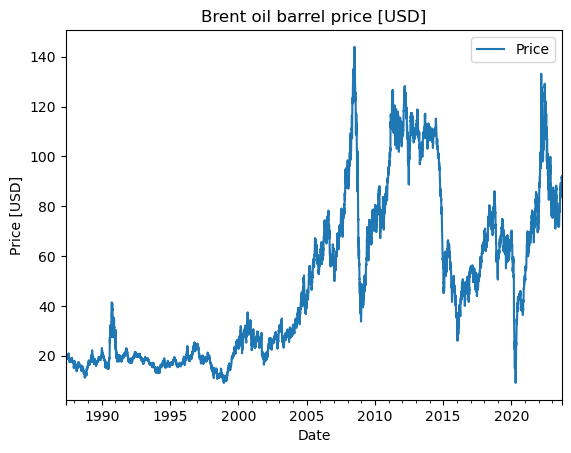

In [560]:
df_oil.plot()
plt.title('Brent oil barrel price [USD]')
plt.xlabel('Date')
plt.ylabel('Price [USD]')
plt.show()

Test ADF FULLER

In [561]:
test_results = adfuller(df_oil.dropna())

print(f"ADF test statistic: {test_results[0]}")
print(f"p-value: {test_results[1]}")
print("Critical thresholds:")

for key, value in test_results[4].items():
    print(f"\t{key}: {value}")

ADF test statistic: -1.9815917818978483
p-value: 0.2947023270984537
Critical thresholds:
	1%: -3.4308446732722064
	5%: -2.8617586220279008
	10%: -2.5668863676031575


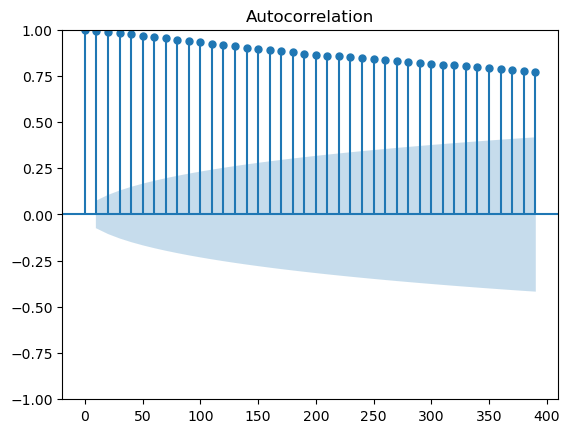

In [562]:
lags = range(0, 400, 10)

plot_acf(df_oil, lags=lags);

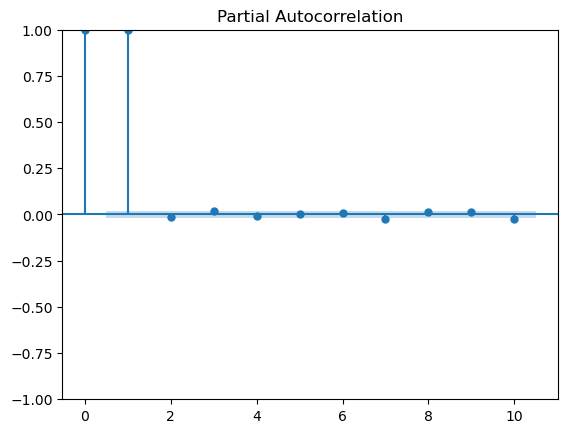

In [563]:
plot_pacf(df_oil, lags=10);

Partición train test

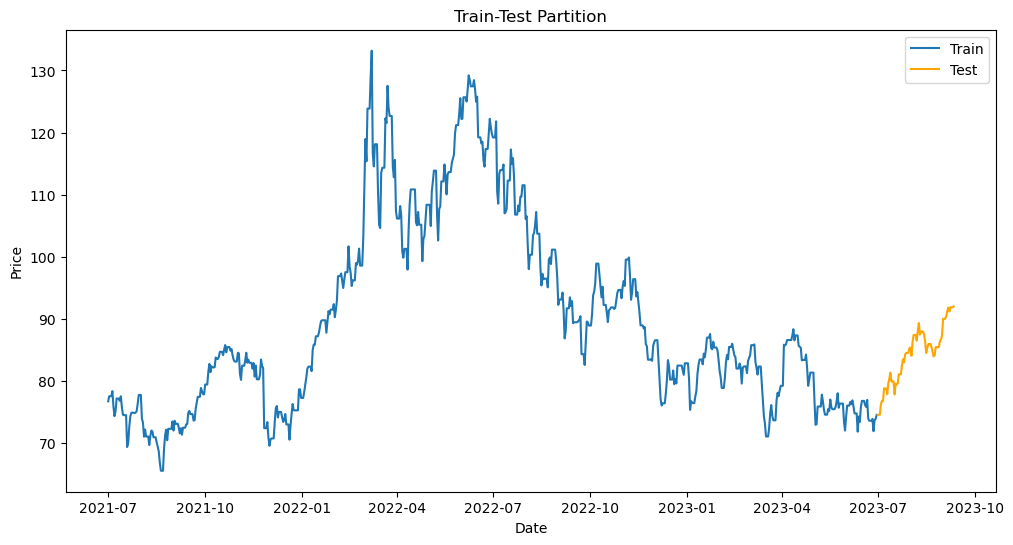

In [847]:
fecha_lim = pd.to_datetime('2023-07-01')

df_train = df_oil[df_oil.index < fecha_lim]
df_test = df_oil[df_oil.index >= fecha_lim]

df_train = df_train[-730:]

plt.figure(figsize=(12, 6))
plt.plot(df_train, label='Train')
plt.plot(df_test, color='orange', label='Test')
plt.title('Train-Test Partition')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Descomposición Estacional

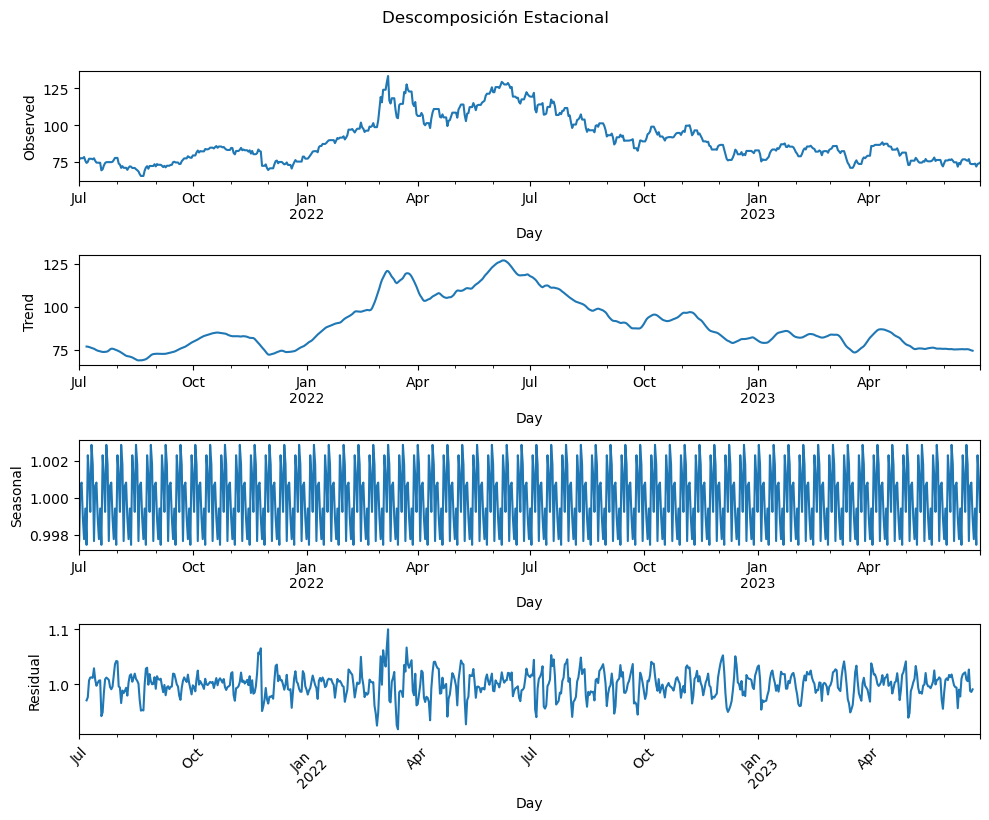

In [850]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_train, model='multiplicative', period=12)

# Ajustar el tamaño de la figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))  # Ajusta el tamaño según tus necesidades

# Graficar los componentes de la descomposición estacional
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

# Ajustar el formato de fecha en el eje x si es necesario
plt.xticks(rotation=45)

# Añadir un título general
plt.suptitle('Descomposición Estacional', y=1.02)

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Diferenciación de la serie

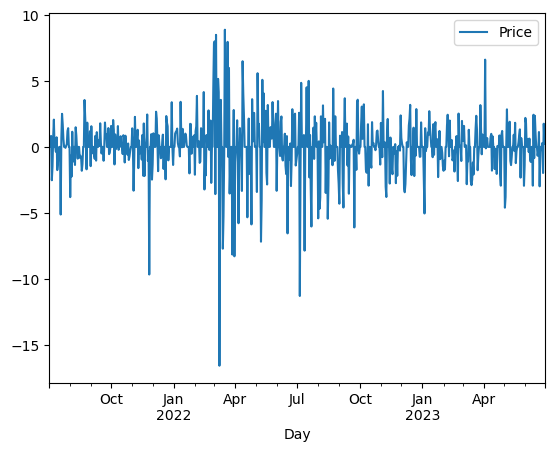

In [851]:
train_diff = df_train.diff().dropna()

train_diff.plot();

Test ADF para serie diferenciada

In [852]:
test_results = adfuller(train_diff)

print(f"ADF test statistic: {test_results[0]}")
print(f"p-value: {test_results[1]}")
print("Critical thresholds:")

for key, value in test_results[4].items():
    print(f"\t{key}: {value}")

ADF test statistic: -11.155295406071945
p-value: 2.8759745493548444e-20
Critical thresholds:
	1%: -3.4394522667904153
	5%: -2.8655569894909805
	10%: -2.568909106765338


Descomposición Estacional serie diferenciada

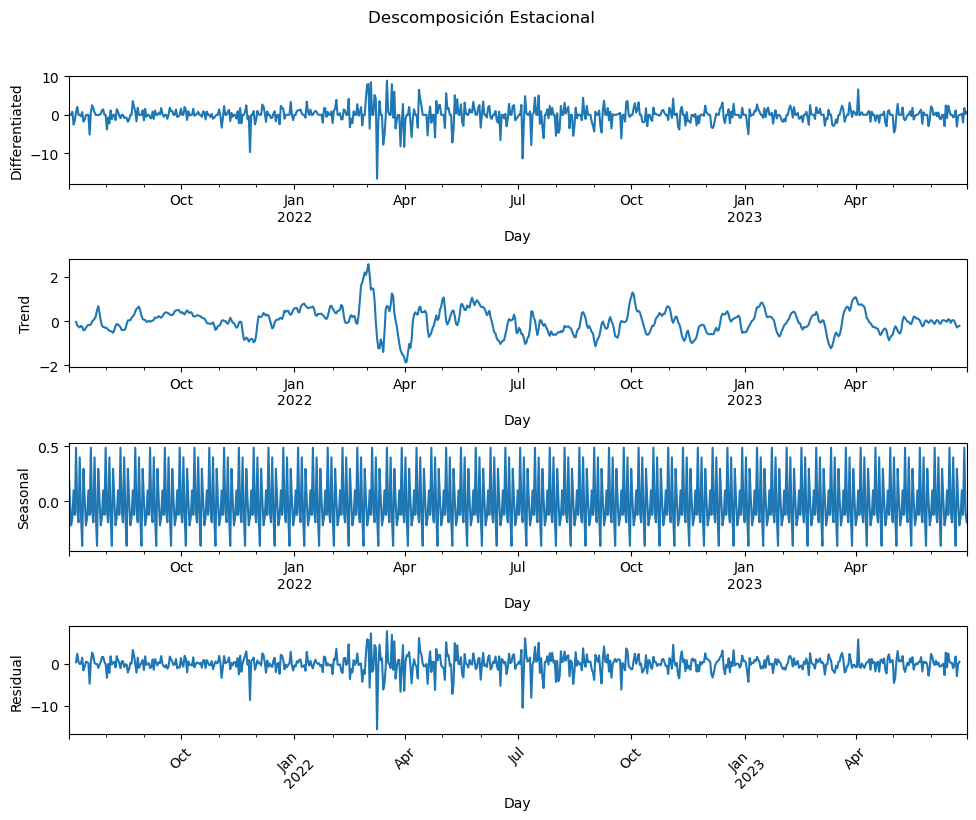

In [853]:
result = seasonal_decompose(train_diff, model='additive', period=12)

# Ajustar el tamaño de la figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))  # Ajusta el tamaño según tus necesidades

# Graficar los componentes de la descomposición estacional
result.observed.plot(ax=ax1)
ax1.set_ylabel('Differentiated')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

# Ajustar el formato de fecha en el eje x si es necesario
plt.xticks(rotation=45)

# Añadir un título general
plt.suptitle('Descomposición Estacional', y=1.02)

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Autocorrelación

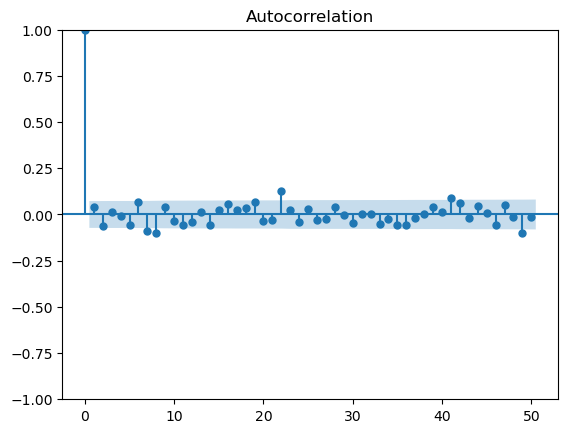

In [799]:
plot_acf(train_diff, lags=50);

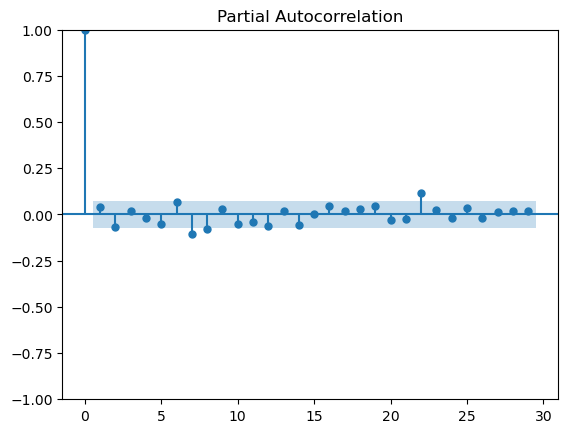

In [854]:
plot_pacf(train_diff);

ARIMA

In [855]:
from statsmodels.tsa.arima.model import ARIMA

p = 1
d = 1
q = 1

daily_train = df_train.tail(730)
daily_test = df_test.head(10)

model = ARIMA(daily_train, order=(p,d,q))

results = model.fit()

forecast = results.get_forecast(steps=len(daily_test))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

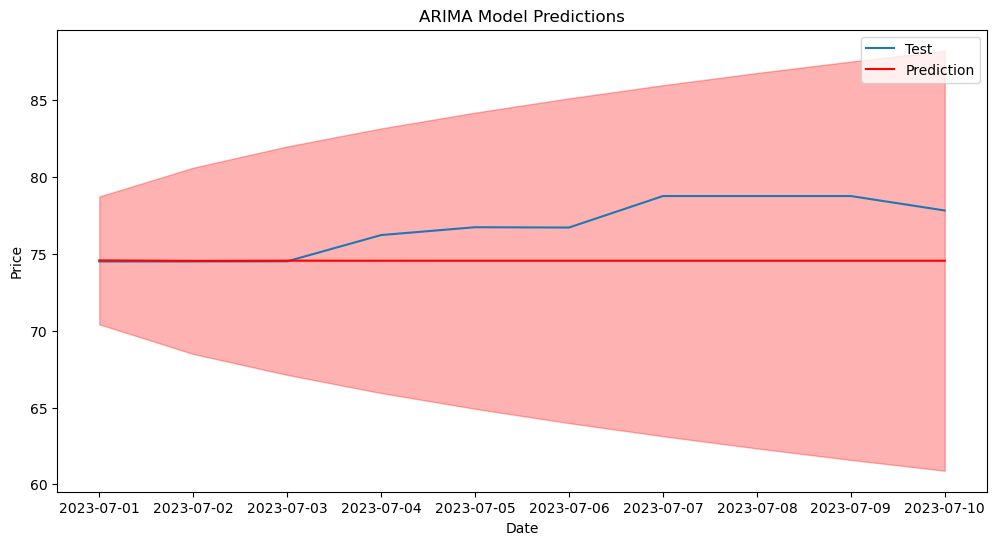

In [856]:
plt.figure(figsize=(12, 6))
plt.plot(daily_test, label='Test')
plt.plot(pred, color='red', label='Prediction')
plt.fill_between(pred.index, conf_int['lower Price'], conf_int['upper Price'], color='red', alpha=0.3)
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [857]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(pred, daily_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 2.758735527071279


In [903]:
import itertools

p = d = q = range(0,4)

pdq = list(itertools.product(p,d,q))

lags = [40, 25, 15]

best_score = 0
best_params = None

for param in pdq:
    for _ in lags:
        try:

            mod = ARIMA(daily_train.tail(_), order=param, 
                        enforce_stationarity = False, 
                        enforce_invertibility = False)
            
            results = mod.fit()
            print('ARIMA{}, {} lags - AIC:{}'.format(param, _, results.aic))

            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_lags = _
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_lags = _

        except:
            continue

print("El mejor modelo es {} con {} lags, \nCon un AIC de {}".format(best_params, _, best_score))



ARIMA(0, 0, 0), 40 lags - AIC:148.62055380769436
ARIMA(0, 0, 0), 25 lags - AIC:91.22650696951067
ARIMA(0, 0, 0), 15 lags - AIC:55.06604688365834
ARIMA(0, 0, 1), 40 lags - AIC:135.00563872472654
ARIMA(0, 0, 1), 25 lags - AIC:83.35247027547787
ARIMA(0, 0, 1), 15 lags - AIC:48.526732724830666
ARIMA(0, 0, 2), 40 lags - AIC:125.52999302840038
ARIMA(0, 0, 2), 25 lags - AIC:75.1632178155074
ARIMA(0, 0, 2), 15 lags - AIC:42.463271295317035
ARIMA(0, 0, 3), 40 lags - AIC:124.1912256164582
ARIMA(0, 0, 3), 25 lags - AIC:73.73870739785431
ARIMA(0, 1, 0), 40 lags - AIC:133.05620786687524
ARIMA(0, 1, 0), 25 lags - AIC:81.45911240321672
ARIMA(0, 1, 0), 15 lags - AIC:43.45917802095527
ARIMA(0, 1, 1), 40 lags - AIC:129.86111346108106
ARIMA(0, 1, 1), 25 lags - AIC:78.5460303268649
ARIMA(0, 1, 1), 15 lags - AIC:41.92222385739817
ARIMA(0, 1, 2), 40 lags - AIC:126.89035687086765
ARIMA(0, 1, 2), 25 lags - AIC:76.26055583888382
ARIMA(0, 1, 2), 15 lags - AIC:41.29756093245231
ARIMA(0, 1, 3), 40 lags - AIC:122.

In [904]:
model = ARIMA(daily_train.tail(best_lags), 
              order=best_params,
              enforce_stationarity = False,
              enforce_invertibility = False)

results = model.fit()

forecast = results.get_forecast(steps=len(daily_test))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

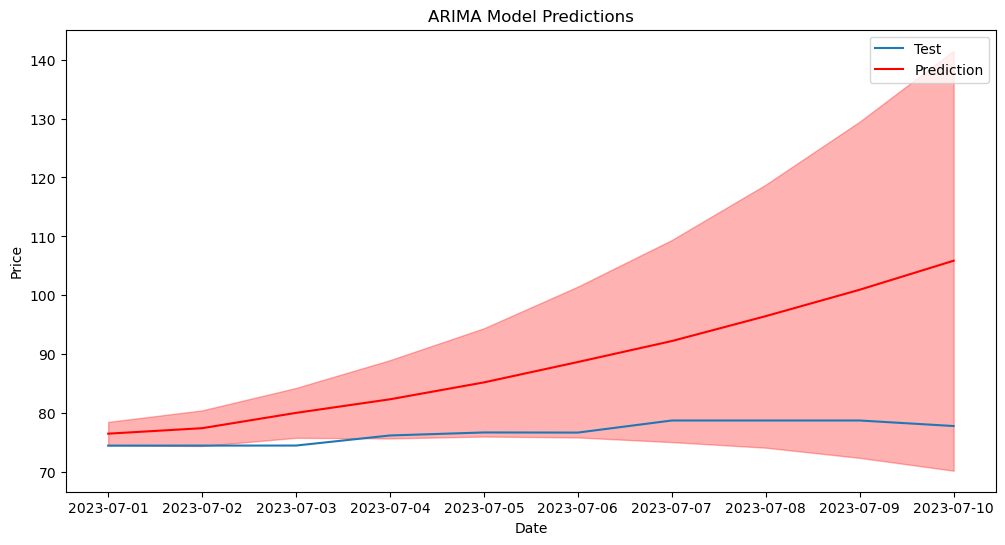

In [905]:
plt.figure(figsize=(12, 6))
plt.plot(daily_test, label='Test')
plt.plot(pred, color='red', label='Prediction')
plt.fill_between(pred.index, conf_int['lower Price'], conf_int['upper Price'], color='red', alpha=0.3)
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [906]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(pred, daily_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 14.390056579402168


In [907]:
pred_ARIMA_1 = pred

In [929]:
model = ARIMA(daily_train.tail(best_lags), 
              order=(0,3,2),
              enforce_stationarity = False,
              enforce_invertibility = False)

results = model.fit()

forecast = results.get_forecast(steps=len(daily_test))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

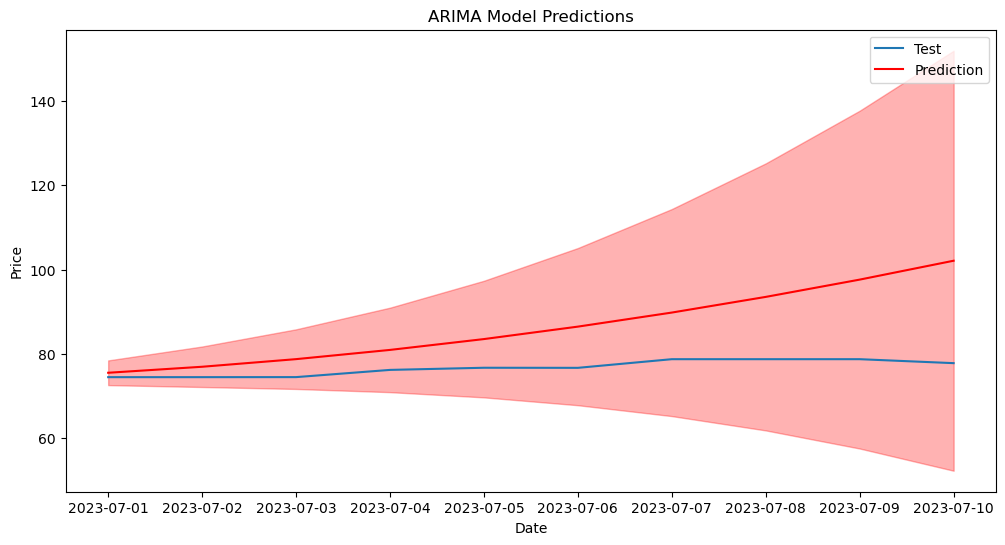

In [930]:
plt.figure(figsize=(12, 6))
plt.plot(daily_test, label='Test')
plt.plot(pred, color='red', label='Prediction')
plt.fill_between(pred.index, conf_int['lower Price'], conf_int['upper Price'], color='red', alpha=0.3)
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [931]:
rmse = sqrt(mean_squared_error(pred, daily_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 12.144731693545365


In [932]:
pred_ARIMA_2 = pred

In [933]:
model = ARIMA(daily_train.tail(best_lags), 
              order=(1, 2, 3),
              enforce_stationarity = False,
              enforce_invertibility = False)

results = model.fit()

forecast = results.get_forecast(steps=len(daily_test))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

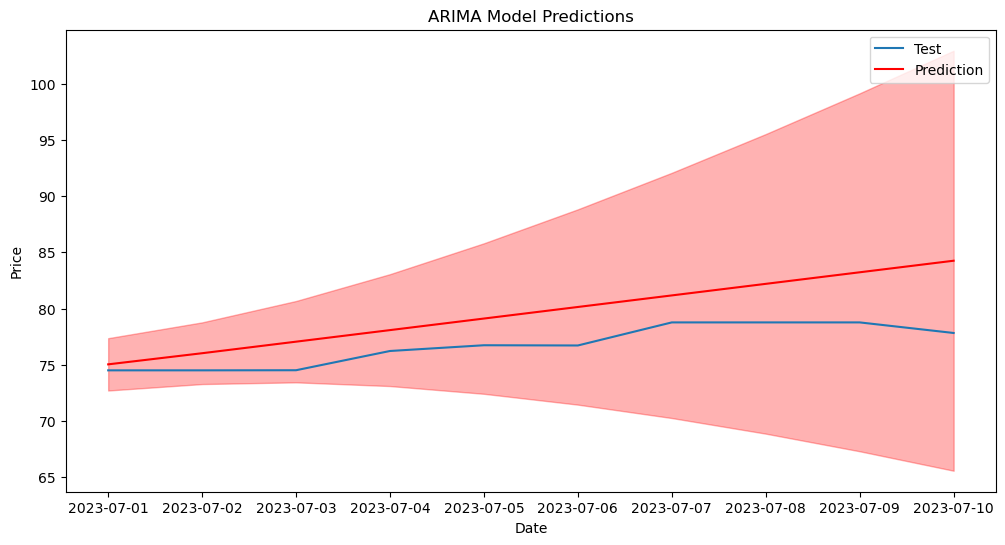

In [934]:
plt.figure(figsize=(12, 6))
plt.plot(daily_test, label='Test')
plt.plot(pred, color='red', label='Prediction')
plt.fill_between(pred.index, conf_int['lower Price'], conf_int['upper Price'], color='red', alpha=0.3)
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [935]:
rmse = sqrt(mean_squared_error(pred, daily_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 3.292081704323027


In [936]:
pred_ARIMA = pred


In [937]:
pred_ARIMA

2023-07-01    75.042444
2023-07-02    76.031552
2023-07-03    77.057800
2023-07-04    78.085425
2023-07-05    79.113101
2023-07-06    80.140779
2023-07-07    81.168458
2023-07-08    82.196136
2023-07-09    83.223814
2023-07-10    84.251492
Freq: D, Name: predicted_mean, dtype: float64

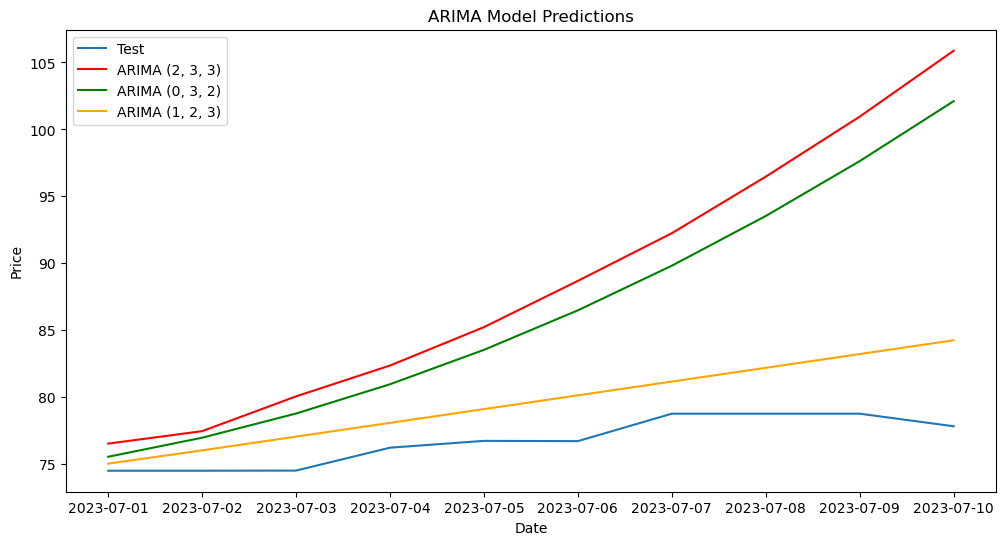

In [938]:
plt.figure(figsize=(12, 6))
plt.plot(daily_test, label='Test')
plt.plot(pred_ARIMA_1, color='red', label='ARIMA (2, 3, 3)')
plt.plot(pred_ARIMA_2, color='green', label='ARIMA (0, 3, 2)')
plt.plot(pred_ARIMA, color='orange', label='ARIMA (1, 2, 3)')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA Mensual

In [945]:
df_monthly = df_oil.resample('M').last()

In [946]:
monthly_train = df_monthly[df_monthly.index < fecha_lim].tail(100)
monthly_test = df_monthly[df_monthly.index >= fecha_lim].head(2)

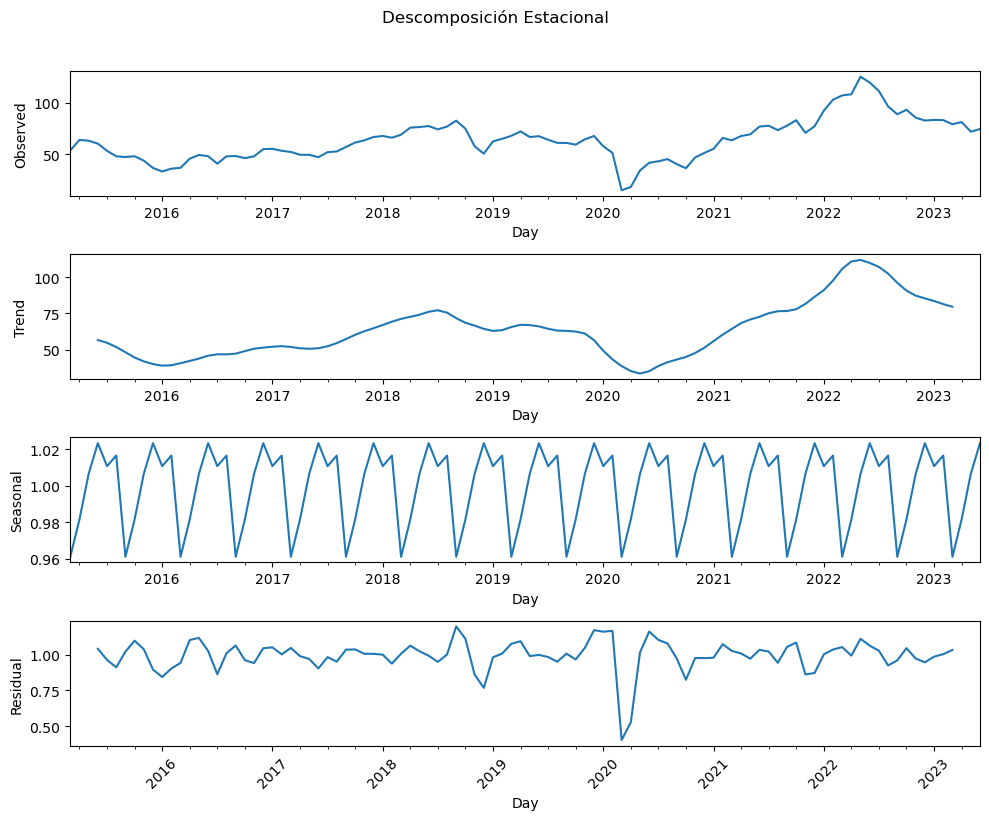

In [947]:
result = seasonal_decompose(monthly_train, model='multiplicative', period=6)

# Ajustar el tamaño de la figura
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))  # Ajusta el tamaño según tus necesidades

# Graficar los componentes de la descomposición estacional
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

# Ajustar el formato de fecha en el eje x si es necesario
plt.xticks(rotation=45)

# Añadir un título general
plt.suptitle('Descomposición Estacional', y=1.02)

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [1011]:
p = d = q = range(0,4)

pdq = list(itertools.product(p,d,q))

lags = [12, 6, 3]

best_score = 0
best_params = None

for param in pdq:
    for _ in lags:
        try:

            mod = ARIMA(monthly_train.tail(_), order=param, 
                        enforce_stationarity = False, 
                        enforce_invertibility = False)
            
            results = mod.fit()
            print('ARIMA{}, {} lags - AIC:{}'.format(param, _, results.aic))

            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_lags = _
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_lags = _

        except:
            continue

print("El mejor modelo es {} con {} lags, \nCon un AIC de {}".format(best_params, _, best_score))



ARIMA(0, 0, 0), 12 lags - AIC:77.98334907834118
ARIMA(0, 0, 0), 6 lags - AIC:32.52855483628353
ARIMA(0, 0, 0), 3 lags - AIC:10.616042621647162
ARIMA(0, 0, 1), 12 lags - AIC:66.18052992945164
ARIMA(0, 0, 1), 6 lags - AIC:27.807118340002987
ARIMA(0, 0, 2), 12 lags - AIC:62.589507341221214
ARIMA(0, 1, 0), 12 lags - AIC:62.942051185773124
ARIMA(0, 1, 0), 6 lags - AIC:26.76281978337545
ARIMA(0, 1, 0), 3 lags - AIC:6.694315672762891
ARIMA(0, 1, 1), 12 lags - AIC:56.38522597594827
ARIMA(0, 1, 1), 6 lags - AIC:22.469473357904576
ARIMA(0, 1, 2), 12 lags - AIC:52.224342843376846
ARIMA(0, 2, 0), 12 lags - AIC:66.09076129698329
ARIMA(0, 2, 0), 6 lags - AIC:24.430222581587635
ARIMA(0, 2, 1), 12 lags - AIC:51.92595650959164
ARIMA(0, 2, 2), 12 lags - AIC:42.29768520179342
ARIMA(0, 3, 0), 12 lags - AIC:68.27148867664326
ARIMA(0, 3, 0), 6 lags - AIC:19.792177299864203
ARIMA(0, 3, 0), 3 lags - AIC:2.0
ARIMA(0, 3, 1), 12 lags - AIC:52.41256729993432
ARIMA(1, 0, 0), 12 lags - AIC:67.04057710057647
ARIMA(1

In [1016]:
model = ARIMA(monthly_train.tail(best_lags), 
              order=best_params,
              enforce_stationarity = False,
              enforce_invertibility = False)

results = model.fit()

forecast = results.get_forecast(steps=len(monthly_test))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

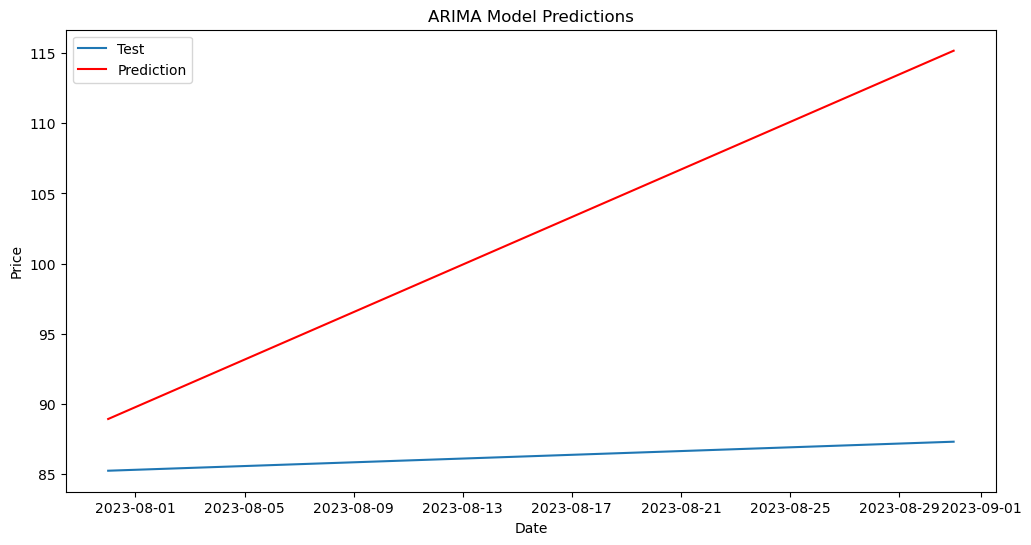

In [1017]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_test, label='Test')
plt.plot(pred, color='red', label='Prediction')
plt.fill_between(pred.index, conf_int['lower Price'], conf_int['upper Price'], color='red', alpha=0.3)
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [1018]:
rmse = sqrt(mean_squared_error(pred, monthly_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 19.893066631368054


In [1019]:
predM_ARIMA_1 = pred

In [1020]:
model = ARIMA(monthly_train.tail(6), 
              order=(2, 1, 1),
              enforce_stationarity = False,
              enforce_invertibility = False)

results = model.fit()

forecast = results.get_forecast(steps=len(monthly_test))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

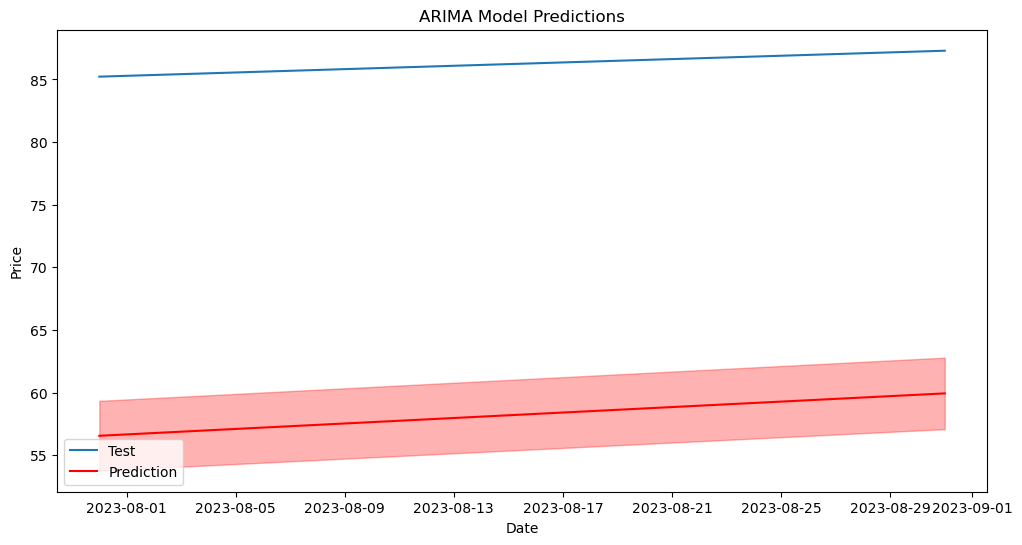

In [1021]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_test, label='Test')
plt.plot(pred, color='red', label='Prediction')
plt.fill_between(pred.index, conf_int['lower Price'], conf_int['upper Price'], color='red', alpha=0.3)
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [1022]:
rmse = sqrt(mean_squared_error(pred, monthly_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 28.01545903520571


In [1023]:
predM_ARIMA_2 = pred

In [1030]:
model = ARIMA(monthly_train.tail(6), 
              order=(0, 1, 0),
              enforce_stationarity = False,
              enforce_invertibility = False)

results = model.fit()

forecast = results.get_forecast(steps=len(monthly_test))

pred = forecast.predicted_mean
conf_int = forecast.conf_int()

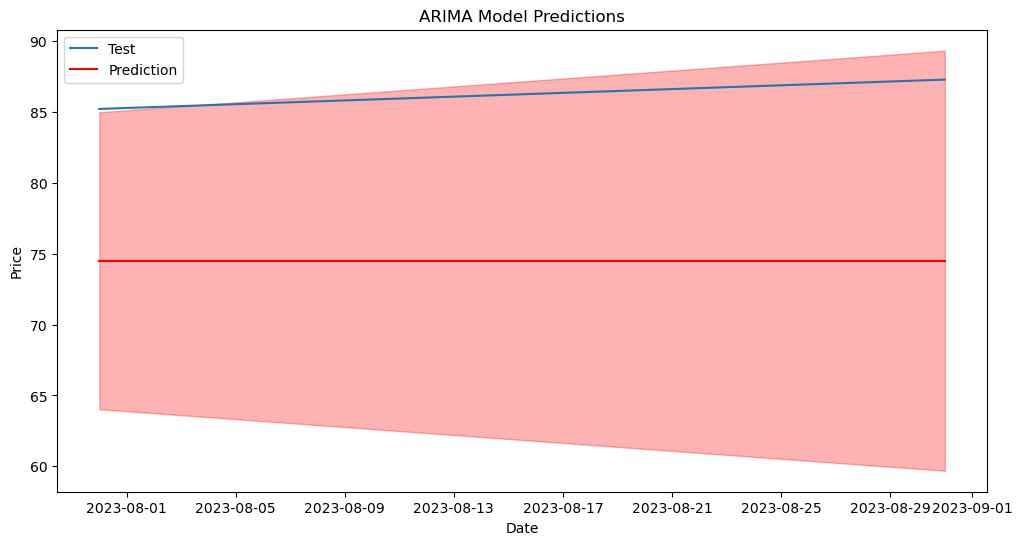

In [1031]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_test, label='Test')
plt.plot(pred, color='red', label='Prediction')
plt.fill_between(pred.index, conf_int['lower Price'], conf_int['upper Price'], color='red', alpha=0.3)
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [1032]:
rmse = sqrt(mean_squared_error(pred, monthly_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 11.79051525591651


In [1027]:
predM_ARIMA = pred

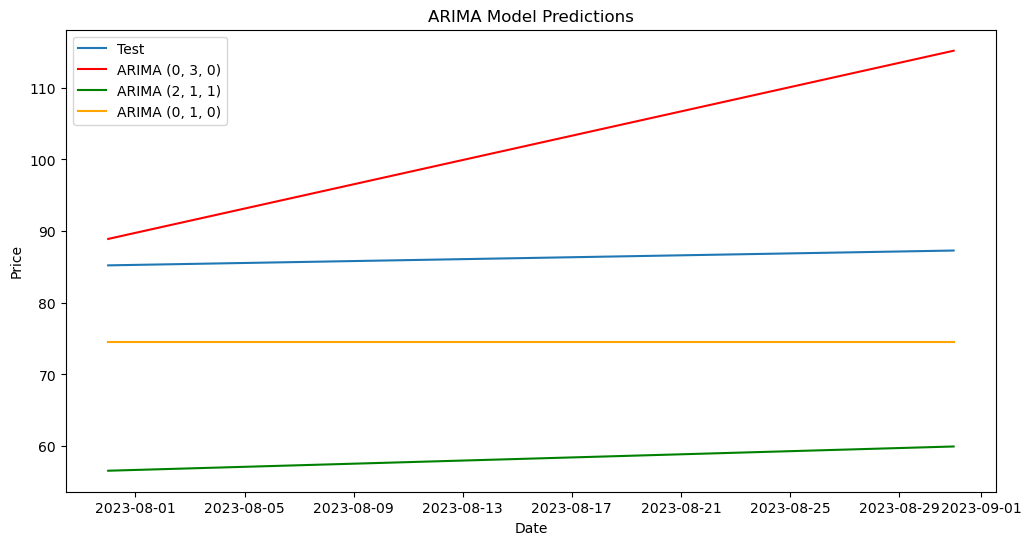

In [1033]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_test, label='Test')
plt.plot(predM_ARIMA_1, color='red', label='ARIMA (0, 3, 0)')
plt.plot(predM_ARIMA_2, color='green', label='ARIMA (2, 1, 1)')
plt.plot(predM_ARIMA, color='orange', label='ARIMA (0, 1, 0)')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

MODELO CONVENCIONAL

In [1039]:
daily_train = df_train.tail(730)
daily_test = df_test.head(10)

conf_interval = [10, 90]


In [1130]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import matplotlib.dates as mdates

forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 30
)

forecaster.fit(y = daily_train['Price'])

In [1131]:
steps = len(daily_test)

predictions = forecaster.predict_interval(steps = steps, interval=conf_interval)


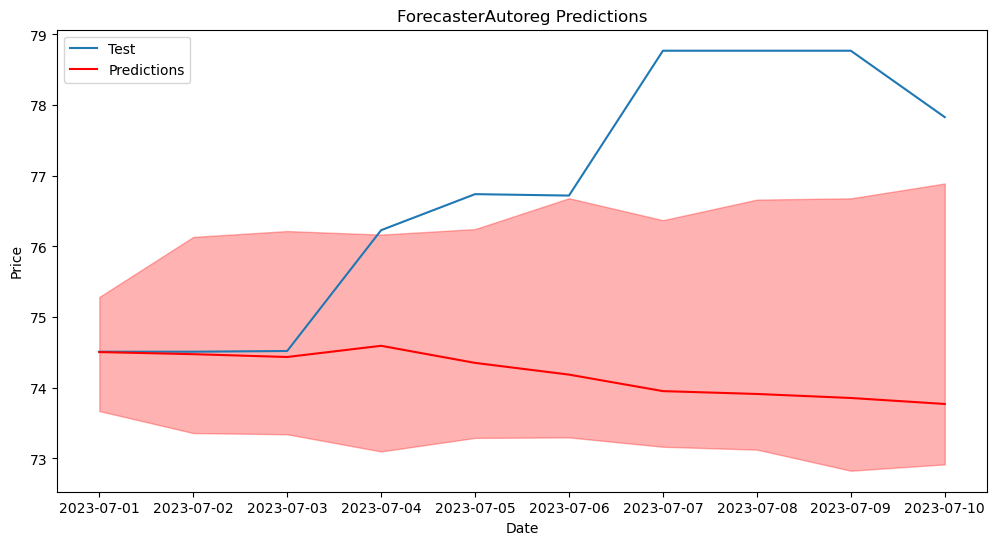

In [1134]:
plt.figure(figsize=(12, 6))
plt.plot(daily_test, label='Test')
plt.plot(predictions['pred'], color='red', label='Predictions')
plt.fill_between(predictions.index, predictions['lower_bound'], predictions['upper_bound'], color='red', alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('ForecasterAutoreg Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [1135]:
rmse = sqrt(mean_squared_error(predictions['pred'], daily_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 3.197873138040335


In [1097]:
from skforecast.model_selection import grid_search_forecaster

forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=42),
                 lags      = 10 # Placeholder, the value will be overwritten
             )


# Lags used as predictors
lags_grid = [7, 14, 25]

# Regressor hyperparameters
param_grid = {'n_estimators': [ 50, 100, 200],
              'max_depth': [5, 10, 20, 30]}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = daily_train['Price'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   refit              = True,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(daily_train) -1,
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 36.


lags grid: 100%|██████████| 3/3 [01:06<00:00, 22.15s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 3.142028708657916e-06



In [1099]:
results_grid.head(5)

,lags,params,mean_squared_error,max_depth,n_estimators
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]","{'max_depth': 10, 'n_estimators': 50}",0.000003,10,50
5,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 10, 'n_estimators': 200}",0.000023,10,200
8,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 20, 'n_estimators': 200}",0.000215,20,200
11,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 30, 'n_estimators': 200}",0.000215,30,200
27,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 50}",0.000217,10,50


In [1100]:
ind = 1

print(results_grid.iloc[ind]['lags'])
print(results_grid.iloc[ind]['params'])

[1 2 3 4 5 6 7]
{'max_depth': 10, 'n_estimators': 200}


In [1489]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10,
                                                      n_estimators=50),
                lags = 25
)

forecaster.fit(y = daily_train['Price'])

In [1490]:
steps = len(daily_test)

predictions = forecaster.predict_interval(steps = steps, 
                                          interval=conf_interval)

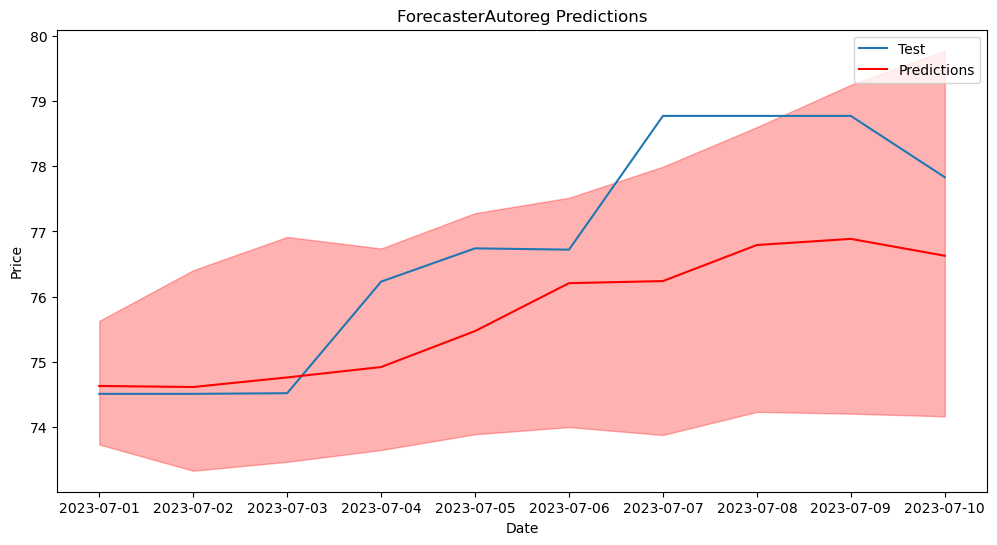

In [1491]:
plt.figure(figsize=(12, 6))
plt.plot(daily_test, label='Test')
plt.plot(predictions['pred'], color='red', label='Predictions')
plt.fill_between(predictions.index, predictions['lower_bound'], predictions['upper_bound'], color='red', alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('ForecasterAutoreg Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [1493]:
rmse = sqrt(mean_squared_error(predictions['pred'], daily_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 1.3781195959947052


In [1494]:
pred_FA = predictions

ForecastAutoregCustom

In [1211]:
def custom_predictors(y):

    lags_value = 2
    window_size = 7
    
    lags = y[-1:-lags_value:-1]
    mean = np.mean(y[-window_size:])
    predictors = np.hstack([lags, mean])
    
    return predictors

In [1432]:
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom

forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 7
             )

forecaster.fit(y=daily_train['Price'])

In [1433]:
steps = len(daily_test)

predictions = forecaster.predict_interval(steps = steps, interval=conf_interval)

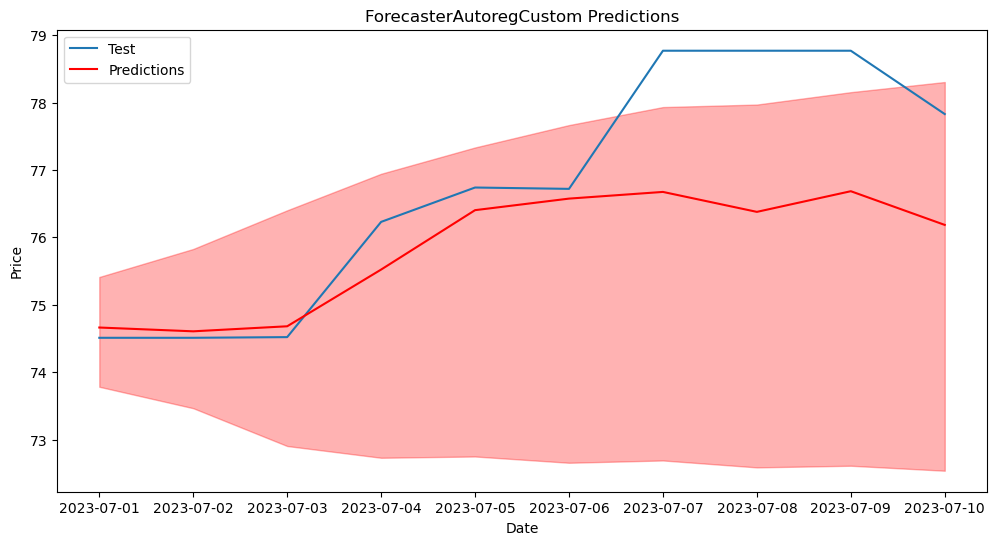

In [1434]:
plt.figure(figsize=(12, 6))
plt.plot(daily_test, label='Test')
plt.plot(predictions['pred'], color='red', label='Predictions')
plt.fill_between(predictions.index, predictions['lower_bound'], predictions['upper_bound'], color='red', alpha=0.3)
plt.title('ForecasterAutoregCustom Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [1435]:
rmse = sqrt(mean_squared_error(predictions['pred'], daily_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 1.3361827015794068


In [1436]:
pred_FAC_1 = predictions

In [1437]:
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 7
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [5, 10, 25, 50, 100],
              'max_depth': [None, 5, 10, 50]}

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = daily_train['Price'],
                    param_grid         = param_grid,
                    steps              = steps,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    initial_train_size = len(daily_train['Price'])-2,
                    fixed_train_size   = False,
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
               ) 

Number of models compared: 20.


lags grid: 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.023723175612540927



In [1438]:
results_grid.head(5)

,lags,params,mean_squared_error,max_depth,n_estimators
14,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.023723,10.0,100.0
13,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.024211,10.0,50.0
2,custom predictors,"{'max_depth': None, 'n_estimators': 25}",0.028306,NaN,25.0
17,custom predictors,"{'max_depth': 50, 'n_estimators': 25}",0.028306,50.0,25.0
3,custom predictors,"{'max_depth': None, 'n_estimators': 50}",0.042792,NaN,50.0


In [1439]:
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor( max_depth=None, 
                                                       n_estimators=25,
                                                        random_state=39),
                fun_predictors = custom_predictors,
                window_size    = 7
             )

forecaster.fit(y=daily_train['Price'])

steps = len(daily_test)

predictions = forecaster.predict_interval(steps = steps, interval=conf_interval)
  

rmse = sqrt(mean_squared_error(predictions['pred'], daily_test))

print(f'La RMSE del modelo es: {rmse}')


La RMSE del modelo es: 0.7638770791167813


In [1440]:
pred_FAC = predictions

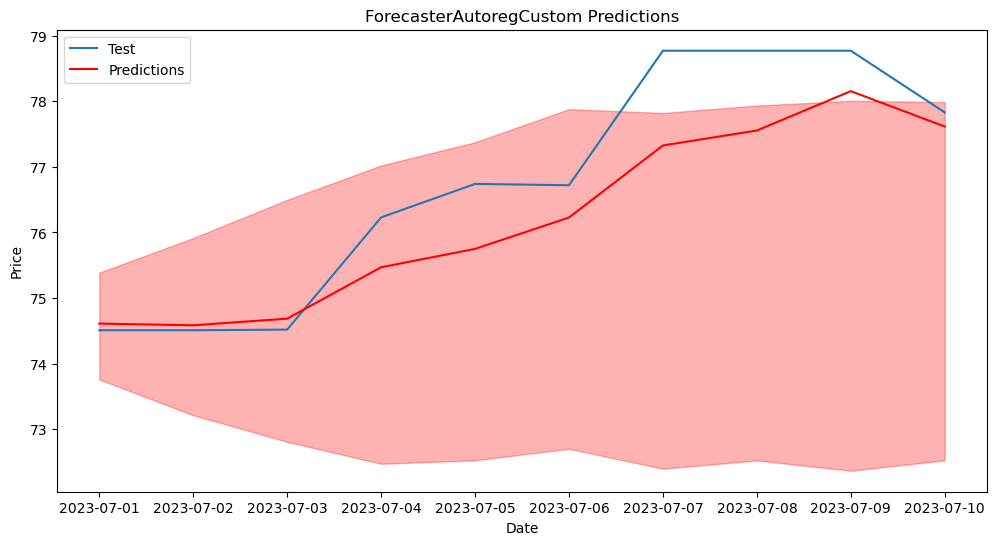

In [1441]:
plt.figure(figsize=(12, 6))
plt.plot(daily_test, label='Test')
plt.plot(predictions['pred'], color='red', label='Predictions')
plt.fill_between(predictions.index, predictions['lower_bound'], predictions['upper_bound'], color='red', alpha=0.3)
plt.title('ForecasterAutoregCustom Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Comparacion modelos FAC y FA

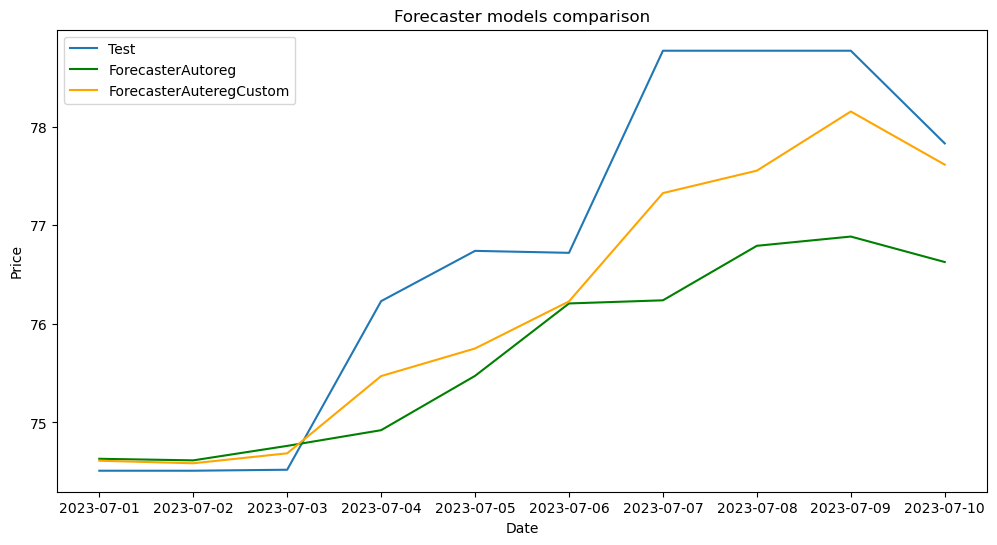

In [1537]:
plt.figure(figsize=(12, 6))
plt.plot(daily_test, label='Test')
plt.plot(pred_FA['pred'], color='green', label='ForecasterAutoreg')
plt.plot(pred_FAC['pred'], color='orange', label='ForecasterAuteregCustom' )
plt.title('Forecaster models comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Monthly Prediction

In [1453]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 2
)

forecaster.fit(y = monthly_train['Price'])

In [1454]:
steps = len(monthly_test)

predictions = forecaster.predict_interval(steps = steps, interval=conf_interval)

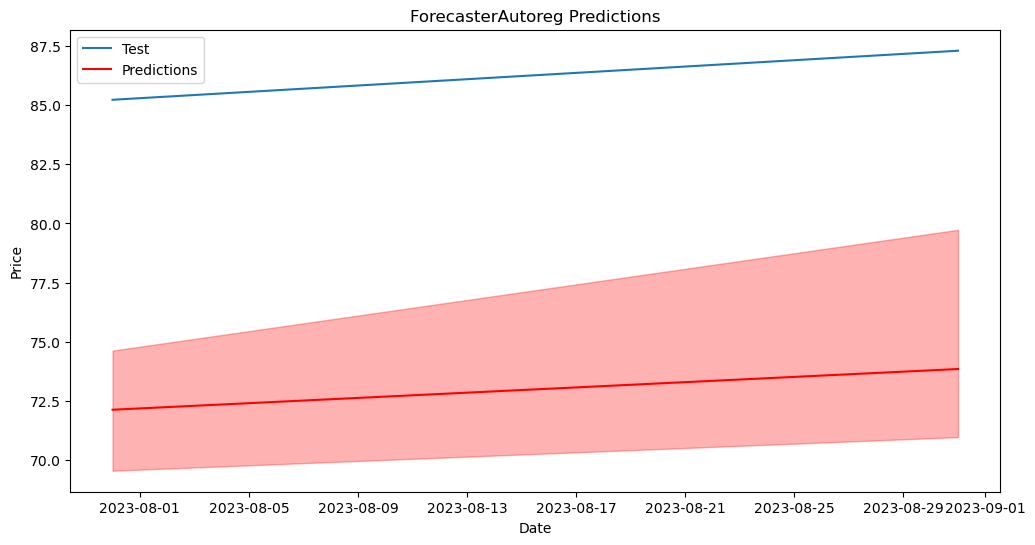

In [1455]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_test, label='Test')
plt.plot(predictions['pred'], color='red', label='Predictions')
plt.fill_between(predictions.index, predictions['lower_bound'], predictions['upper_bound'], color='red', alpha=0.3)
plt.title('ForecasterAutoreg Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [1457]:
rmse = sqrt(mean_squared_error(predictions['pred'], monthly_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 13.25956281028907


In [1460]:
monthly_train

,Price
Day,
2015-03-31,53.69
2015-04-30,63.90
2015-05-31,63.16
2015-06-30,60.31
2015-07-31,53.29
...,...
2023-02-28,83.21
2023-03-31,79.19
2023-04-30,81.32


In [1497]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=30),
                 lags      = 10 # Placeholder, the value will be overwritten
             )


# Lags used as predictors
lags_grid = [12, 20]

# Regressor hyperparameters
param_grid = {'n_estimators': [30, 100],
              'max_depth': [None, 5, 20]}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = monthly_train['Price'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 6,
                   refit              = True,
                   metric             = 'mean_squared_error',
                   initial_train_size = len(monthly_train)-1,
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 12.


lags grid: 100%|██████████| 2/2 [00:17<00:00,  8.62s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 5, 'n_estimators': 30}
  Backtesting metric: 0.012411993575362434



In [1480]:
results_grid.head(5)

,lags,params,mean_squared_error,max_depth,n_estimators
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 30}",0.012412,5.0,30.0
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': None, 'n_estimators': 30}",0.033245,NaN,30.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 20, 'n_estimators': 30}",0.033245,20.0,30.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.190197,5.0,100.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 30}",0.607156,5.0,30.0


In [1541]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state= 15, max_depth=None,
                                                      n_estimators=2),
                lags = 12
    )

forecaster.fit(y = monthly_train['Price'])
    
steps = len(monthly_test)

predictions = forecaster.predict_interval(steps = steps, interval=conf_interval)


rmse = sqrt(mean_squared_error(predictions['pred'], monthly_test))

print(f'La RMSE del modelo es: {rmse}')

La RMSE del modelo es: 1.3122880781291826


In [1542]:
predM_FA = predictions

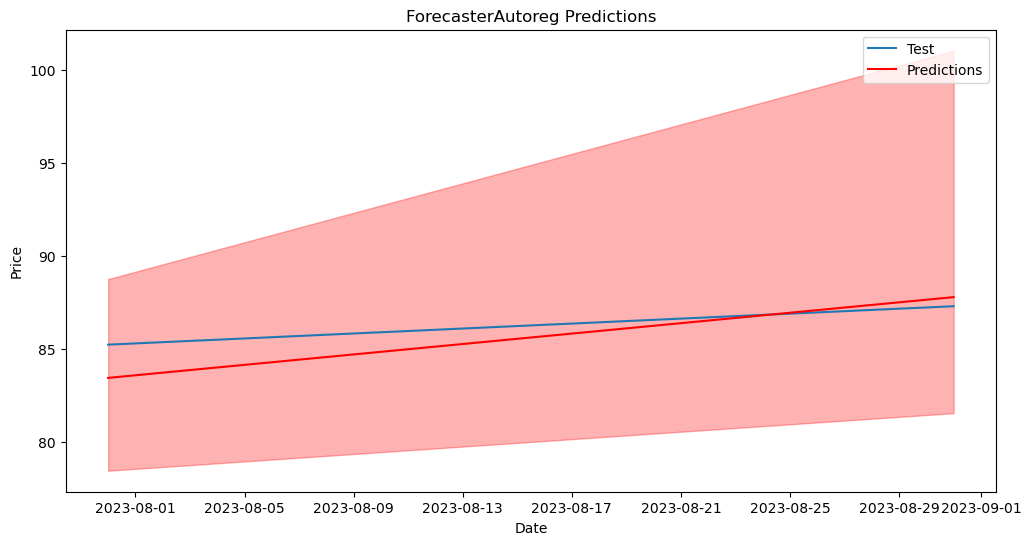

In [1543]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_test, label='Test')
plt.plot(predictions['pred'], color='red', label='Predictions')
plt.fill_between(predictions.index, predictions['lower_bound'], predictions['upper_bound'], color='red', alpha=0.3)
plt.title('ForecasterAutoreg Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ForecasterAutoregCustom Monthly Prediction

In [1524]:
def custom_predictors(y):

    lags_value = 12
    window_size = 24
    
    lags = y[-1:-lags_value:-1]
    mean = np.mean(y[-window_size:])
    predictors = np.hstack([lags, mean])
    
    return predictors

In [1532]:
temp_rmse = []
temp_pred = []
temp_random = []

for _ in range(1, 100, 2):

    forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor( max_depth=5, 
                                                       n_estimators=3,
                                                        random_state=_),
                fun_predictors = custom_predictors,
                window_size    = 24
             )

    forecaster.fit(y=monthly_train['Price'])

    steps = len(monthly_test)

    predictions = forecaster.predict_interval(steps = steps, interval=conf_interval)
  

    rmse = sqrt(mean_squared_error(predictions['pred'], monthly_test))

    print(f'La RMSE del modelo es: {rmse}')

    temp_rmse.append(rmse)
    temp_pred.append(predictions)
    temp_random.append(_)

    if rmse < 2:
        break

La RMSE del modelo es: 30.721986559518992
La RMSE del modelo es: 6.5206672085026165
La RMSE del modelo es: 22.9483408062854
La RMSE del modelo es: 24.65375473572828
La RMSE del modelo es: 21.341423110278136
La RMSE del modelo es: 21.39184640512232
La RMSE del modelo es: 29.880491013605326
La RMSE del modelo es: 24.401572464415302
La RMSE del modelo es: 4.824162096949242
La RMSE del modelo es: 13.779441409416984
La RMSE del modelo es: 30.046433487103336
La RMSE del modelo es: 23.690931179430965
La RMSE del modelo es: 18.88118489952038
La RMSE del modelo es: 24.41814020784295
La RMSE del modelo es: 16.631023393378744
La RMSE del modelo es: 4.476298694233899
La RMSE del modelo es: 26.434476564414286
La RMSE del modelo es: 19.356788956231924
La RMSE del modelo es: 32.11417324344185
La RMSE del modelo es: 30.887559796046066
La RMSE del modelo es: 22.911459924599804
La RMSE del modelo es: 11.277356846249116
La RMSE del modelo es: 16.117581637686882
La RMSE del modelo es: 22.542270884806413
L

In [1534]:
indice_minimo = np.argmin(temp_rmse)

print(temp_random[indice_minimo])
print(rmse)

61
1.5599999999999956


In [1538]:
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor( max_depth=5, 
                                                       n_estimators=3,
                                                        random_state=61),
                fun_predictors = custom_predictors,
                window_size    = 24
             )

forecaster.fit(y=monthly_train['Price'])

steps = len(monthly_test)

predictions = forecaster.predict_interval(steps = steps, interval=conf_interval)

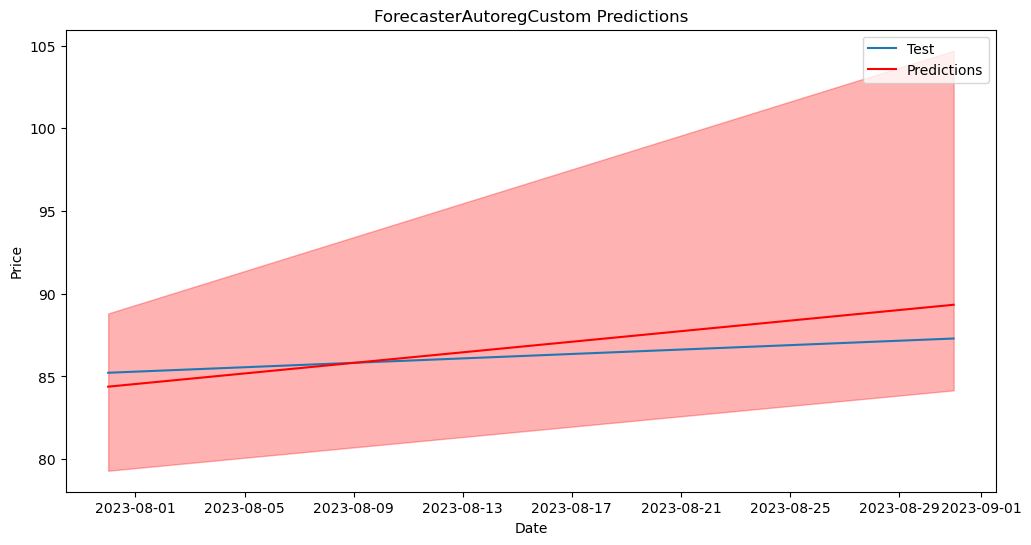

In [1540]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_test, label='Test')
plt.plot(predictions['pred'], color='red', label='Predictions')
plt.fill_between(predictions.index, predictions['lower_bound'], predictions['upper_bound'], color='red', alpha=0.3)
plt.title('ForecasterAutoregCustom Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

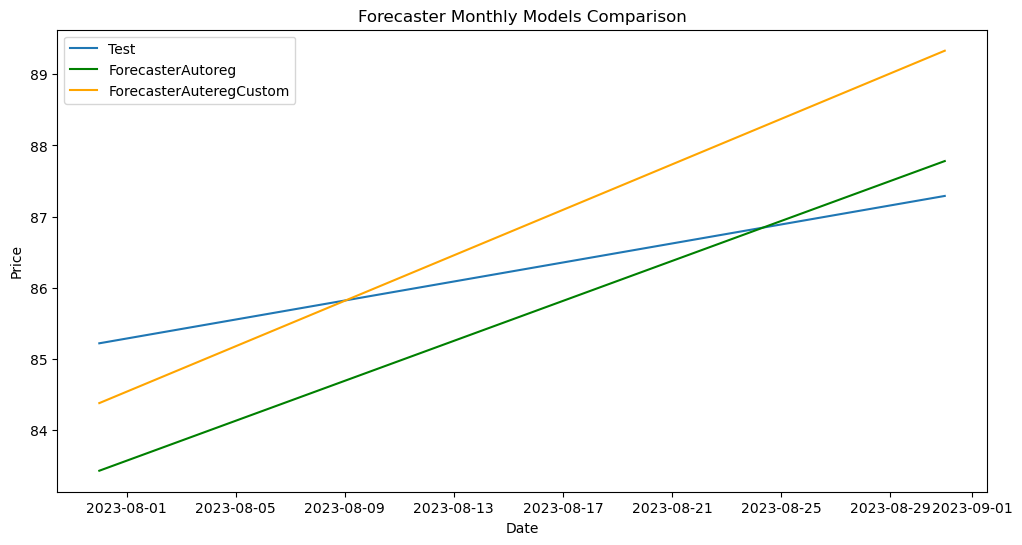

In [1545]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_test, label='Test')
plt.plot(predM_FA['pred'], color='green', label='ForecasterAutoreg')
plt.plot(predM_FAC['pred'], color='orange', label='ForecasterAuteregCustom' )
plt.title('Forecaster Monthly Models Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Comparación Modelos Finales

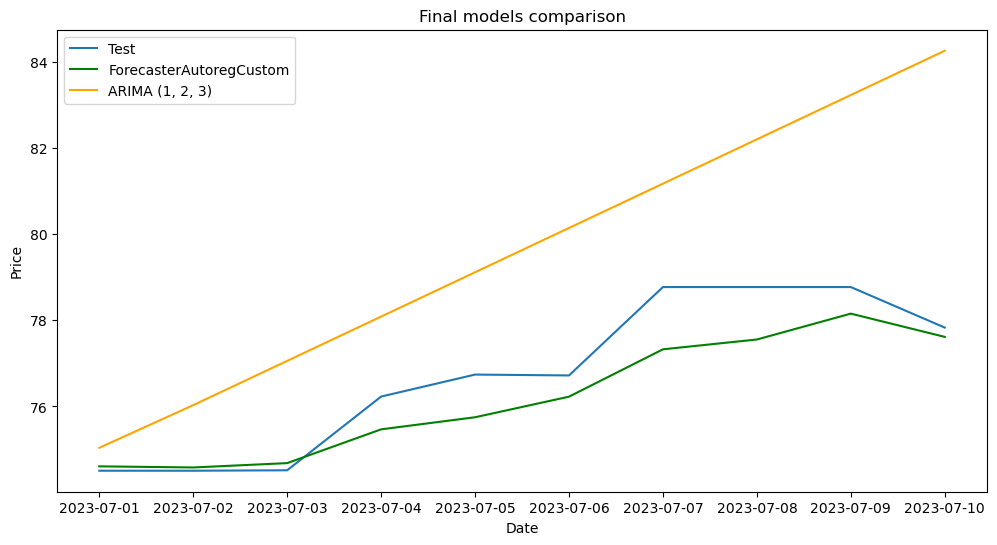

In [1548]:
plt.figure(figsize=(12, 6))
plt.plot(daily_test, label='Test')
plt.plot(pred_FAC['pred'], color='green', label='ForecasterAutoregCustom')
plt.plot(pred_ARIMA, color='orange', label='ARIMA (1, 2, 3)' )
plt.title('Final models comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Métricas de comparación

In [1556]:
np_ARIMA = pred_ARIMA.to_numpy()
np_test = daily_test.to_numpy()
np_FAC = pred_FAC.to_numpy()

In [1561]:
# MAE

mae_ARIMA = np.mean(np.abs(np_ARIMA - np_test))
mae_FAC = np.mean(np.abs(np_FAC - np_test))

naive_forecast = np.full(10, np_test[0]) 
naive_mae = np.mean(np.abs(np_test - naive_forecast))  

mase_ARIMA = mae_ARIMA / naive_mae
mase_FAC = mae_FAC / naive_mae 

print("El MAE del ARIMA es:", mae_ARIMA)
print("El MAE del FAC es:", mae_FAC)
print("El MASE del ARIMA es:", mase_ARIMA)
print("El MASE del FAC es:", mase_FAC)

El MAE del ARIMA es: 3.6561912056755745
El MAE del FAC es: 1.8562133333333302
El MASE del ARIMA es: 1.641756266580864
El MASE del FAC es: 0.8335039664720858


In [1564]:
np_ARIMA = predM_ARIMA.to_numpy()
np_test = monthly_test.to_numpy()
np_FAC = predM_FA.to_numpy()

In [1565]:
mae_ARIMA = np.mean(np.abs(np_ARIMA - np_test))
mae_FAC = np.mean(np.abs(np_FAC - np_test))

naive_forecast = np.full(10, np_test[0]) 
naive_mae = np.mean(np.abs(np_test - naive_forecast))  

mase_ARIMA = mae_ARIMA / naive_mae
mase_FAC = mae_FAC / naive_mae 

print("El MAE del ARIMA es:", mae_ARIMA)
print("El MAE del FAC es:", mae_FAC)
print("El MASE del ARIMA es:", mase_ARIMA)
print("El MASE del FAC es:", mase_FAC)

El MAE del ARIMA es: 11.744999999999997
El MAE del FAC es: 5.353416666666665
El MASE del ARIMA es: 11.347826086956479
El MASE del FAC es: 5.172383252818015


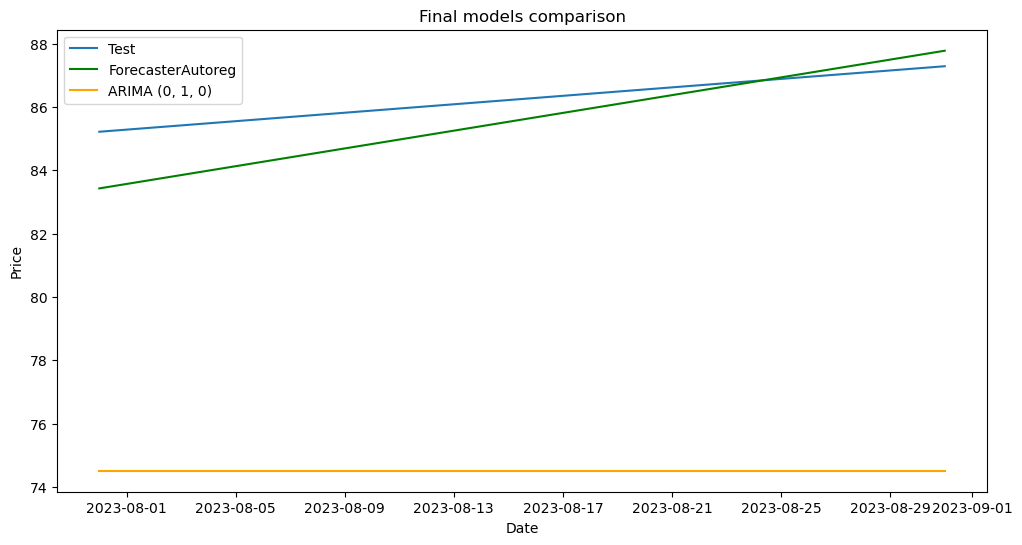

In [1567]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_test, label='Test')
plt.plot(predM_FA['pred'], color='green', label='ForecasterAutoreg')
plt.plot(predM_ARIMA, color='orange', label='ARIMA (0, 1, 0)' )
plt.title('Final models comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()